In [1]:
!pip install pymc arviz numpy pandas matplotlib --quiet


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


ratings = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv')

user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()
active_users = user_counts[user_counts >= 20].index
popular_movies = movie_counts[movie_counts >= 50].index

filtered_ratings = ratings[ratings['userId'].isin(active_users) &
                          ratings['movieId'].isin(popular_movies)]

user_ids = filtered_ratings['userId'].unique()
movie_ids = filtered_ratings['movieId'].unique()
user_id_map = {uid: i for i, uid in enumerate(user_ids)}
movie_id_map = {mid: i for i, mid in enumerate(movie_ids)}

filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_id_map)
filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_id_map)

scaler = StandardScaler()
filtered_ratings['rating_norm'] = scaler.fit_transform(filtered_ratings[['rating']])

num_users = len(user_ids)
num_movies = len(movie_ids)
K = 10

with pm.Model() as bayesian_pmf:
    U = pm.Normal("U", mu=0, sigma=0.1, shape=(num_users, K))
    V = pm.Normal("V", mu=0, sigma=0.1, shape=(num_movies, K))

    user_bias = pm.Normal("user_bias", mu=0, sigma=0.1, shape=num_users)
    movie_bias = pm.Normal("movie_bias", mu=0, sigma=0.1, shape=num_movies)
    global_bias = pm.Normal("global_bias", mu=0, sigma=0.1)

    r_hat = global_bias + user_bias[filtered_ratings['user_idx']] + \
            movie_bias[filtered_ratings['movie_idx']] + \
            pm.math.sum(U[filtered_ratings['user_idx']] * V[filtered_ratings['movie_idx']], axis=1)
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    R = pm.Normal("R", mu=r_hat, sigma=sigma, observed=filtered_ratings['rating_norm'])

<ipython-input-5-1818988422>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_id_map)
<ipython-input-5-1818988422>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_id_map)
<ipython-input-5-1818988422>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [6]:
import arviz as az
trace = az.from_netcdf("/content/drive/MyDrive/bayesian_pmf_trace.nc")
n_train = len(trace.observed_data["R"])
print("Training set size:", n_train)


Training set size: 41360


In [8]:
from sklearn.model_selection import train_test_split
train_ratings, test_ratings = train_test_split(
    filtered_ratings,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
print(f"Train size: {len(train_ratings)}, Test size: {len(test_ratings)}")

# Apply mapping
test_ratings["userId"] = test_ratings["userId"].map(user_id_map)
test_ratings["movieId"] = test_ratings["movieId"].map(movie_id_map)

# Drop unseen IDs
test_ratings = test_ratings.dropna(subset=["userId", "movieId"])

# Convert to int
test_ratings["userId"] = test_ratings["userId"].astype(int)
test_ratings["movieId"] = test_ratings["movieId"].astype(int)

rating_mean = train_ratings['rating'].mean()
rating_std = train_ratings['rating'].std()

Train size: 33088, Test size: 8272


In [9]:
import numpy as np

class BayesianPMFModel:
    def __init__(self, trace, rating_mean=3.5, rating_std=1.0):
        self.trace = trace
        self.rating_mean = rating_mean
        self.rating_std = rating_std

        self.U_all = trace.posterior["U"].stack(sample=("chain", "draw")).transpose("sample", "U_dim_0", "U_dim_1").values
        self.V_all = trace.posterior["V"].stack(sample=("chain", "draw")).transpose("sample", "V_dim_0", "V_dim_1").values
        self.user_bias_all = trace.posterior["user_bias"].stack(sample=("chain", "draw")).transpose("sample", "user_bias_dim_0").values
        self.movie_bias_all = trace.posterior["movie_bias"].stack(sample=("chain", "draw")).transpose("sample", "movie_bias_dim_0").values
        self.global_bias_all = trace.posterior["global_bias"].stack(sample=("chain", "draw")).values.flatten()

    def predict(self, user_id, movie_id):
        u = int(user_id)
        m = int(movie_id)

        u_vec = self.U_all[:, u, :]  # [samples, K]
        v_vec = self.V_all[:, m, :]  # [samples, K]
        dot = np.sum(u_vec * v_vec, axis=1)

        pred_z = dot + self.user_bias_all[:, u] + self.movie_bias_all[:, m] + self.global_bias_all
        pred = pred_z * self.rating_std + self.rating_mean
        return pred.mean()


**Evaluation with Filtered Test Set (Only Known Users/Movies)**


Evaluating predictions...


Evaluating ratings: 100%|██████████| 8272/8272 [00:12<00:00, 686.83it/s]



Universal Evaluation Metrics:
MSE: 0.7278
RMSE: 0.8531
MAE: 0.6555
Inference Time per Prediction: -0.0015 seconds

Generating universal plots...


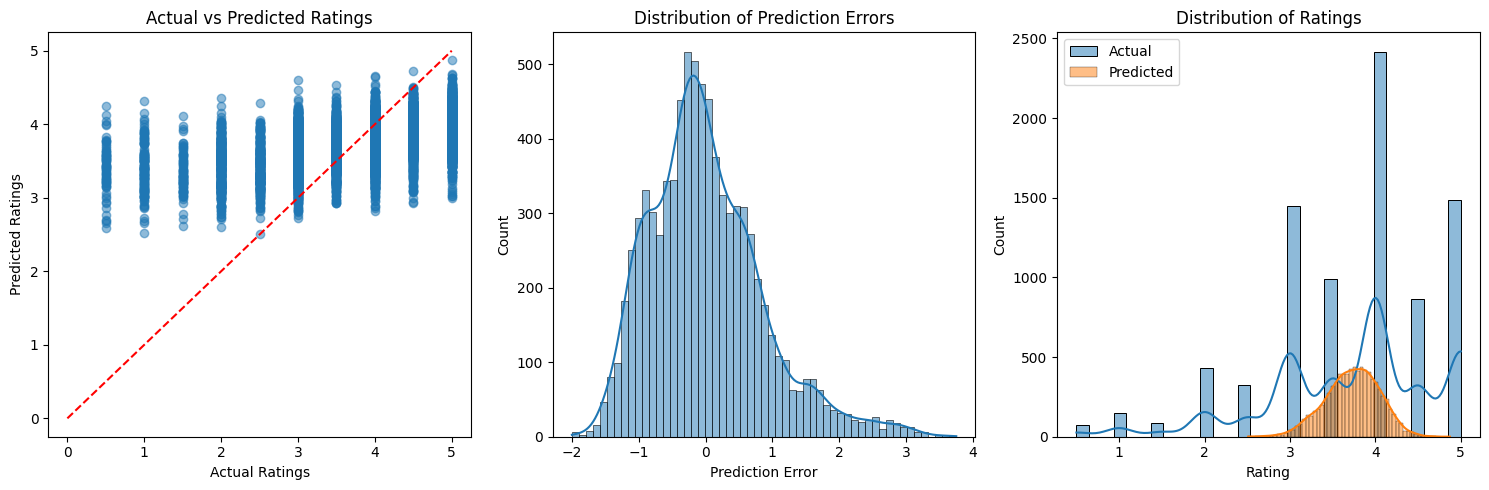

In [10]:
from reporter import BaseRecommenderReporter

model = BayesianPMFModel(trace, rating_mean, rating_std)
reporter = BaseRecommenderReporter()

results = reporter.evaluate_model(model, test_ratings)
reporter.print_stats()
reporter.plot_all()

In [23]:
from data_loader import load_data, split_data
import pandas as pd

ratings = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv')

ratings.drop(columns=['timestamp'], inplace=True)
train_ratings, test_ratings = split_data(ratings)


\nSplitting data...
Training set size: 80668, Test set size: 20168


In [24]:
user_ids = train_ratings['userId'].unique()
movie_ids = train_ratings['movieId'].unique()
user_id_map = {uid: i for i, uid in enumerate(user_ids)}
movie_id_map = {mid: i for i, mid in enumerate(movie_ids)}

train_ratings["user_idx"] = train_ratings["userId"].map(user_id_map)
train_ratings["movie_idx"] = train_ratings["movieId"].map(movie_id_map)


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_ratings["rating_norm"] = scaler.fit_transform(train_ratings[["rating"]])

rating_mean = scaler.mean_[0]
rating_std = scaler.scale_[0]


In [26]:
test_ratings_filtered = test_ratings.copy()

# Apply mapping
test_ratings_filtered["userId"] = test_ratings_filtered["userId"].map(user_id_map)
test_ratings_filtered["movieId"] = test_ratings_filtered["movieId"].map(movie_id_map)

# Drop unseen IDs
test_ratings_filtered = test_ratings_filtered.dropna(subset=["userId", "movieId"])

# Convert to int
test_ratings_filtered["userId"] = test_ratings_filtered["userId"].astype(int)
test_ratings_filtered["movieId"] = test_ratings_filtered["movieId"].astype(int)


In [27]:
import numpy as np

class BayesianPMFModel:
    def __init__(self, trace, rating_mean=3.5, rating_std=1.0):
        self.trace = trace
        self.rating_mean = rating_mean
        self.rating_std = rating_std

        self.U_all = trace.posterior["U"].stack(sample=("chain", "draw")).transpose("sample", "U_dim_0", "U_dim_1").values
        self.V_all = trace.posterior["V"].stack(sample=("chain", "draw")).transpose("sample", "V_dim_0", "V_dim_1").values
        self.user_bias_all = trace.posterior["user_bias"].stack(sample=("chain", "draw")).transpose("sample", "user_bias_dim_0").values
        self.movie_bias_all = trace.posterior["movie_bias"].stack(sample=("chain", "draw")).transpose("sample", "movie_bias_dim_0").values
        self.global_bias_all = trace.posterior["global_bias"].stack(sample=("chain", "draw")).values.flatten()


    def predict(self, user_id, movie_id):
        try:
            u = int(user_id)
            m = int(movie_id)

            u_vec = self.U_all[:, u, :]
            v_vec = self.V_all[:, m, :]
            dot = np.sum(u_vec * v_vec, axis=1)
            pred_z = dot + self.user_bias_all[:, u] + self.movie_bias_all[:, m] + self.global_bias_all
        except IndexError:
            pred_z = np.zeros(self.U_all.shape[0])  # fallback to global bias
        pred = pred_z * self.rating_std + self.rating_mean
        return pred.mean()



**Evaluation with Full Test Set (Including Unseen Users/Movies)**


Evaluating predictions...


Evaluating ratings: 100%|██████████| 20168/20168 [00:05<00:00, 3440.24it/s]



Universal Evaluation Metrics:
MSE: 1.1135
RMSE: 1.0552
MAE: 0.8357
Inference Time per Prediction: -0.0003 seconds

Generating universal plots...


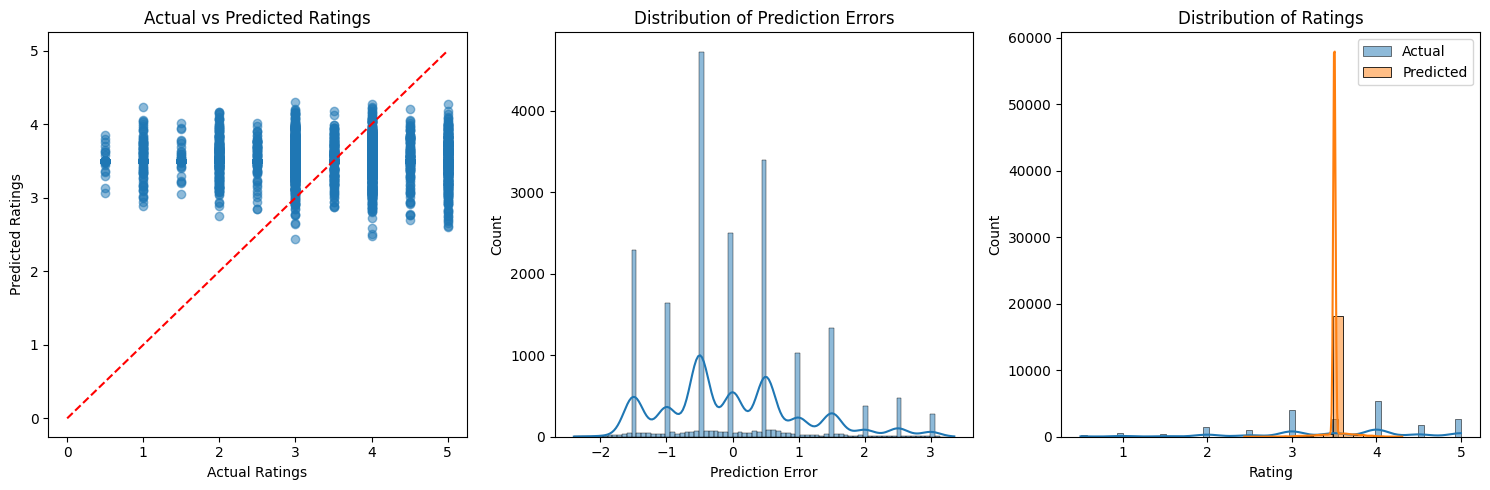

In [29]:
from reporter import BaseRecommenderReporter

model = BayesianPMFModel(trace, rating_mean, rating_std)
reporter = BaseRecommenderReporter()

results = reporter.evaluate_model(model, test_ratings)
reporter.print_stats()
reporter.plot_all()
